# ==========================================
# 1. Imports & Configuration
# ==========================================

In [1]:
from __future__ import annotations

import os
import pickle
from pathlib import Path
import seaborn as sns
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# --- Configuration ---

In [2]:
PROJECT_ROOT = Path("..")  # notebooks/ -> project root
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
FIGURES_DIR = PROJECT_ROOT / "results" / "figures"

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)


def save_plot(filename: str) -> None:
    path = FIGURES_DIR / f"{filename}.png"
    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print(f"[+] Plot saved: {path}")


def load_cleaned_data(processed_dir: Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    train_path = processed_dir / "train_cleaned.csv"
    test_path = processed_dir / "test_cleaned.csv"

    if not train_path.exists() or not test_path.exists():
        raise FileNotFoundError(
            f"Missing cleaned files.\n"
            f"Expected:\n - {train_path}\n - {test_path}\n"
            f"Run 01_data_exploration.ipynb first (and make sure it saved to data/processed/)."
        )

    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    print(f"[+] Loaded Train: {train_df.shape} from {train_path}")
    print(f"[+] Loaded Test : {test_df.shape} from {test_path}")

    return train_df, test_df


# ==========================================
# 2. Load Cleaned Data
# ==========================================

In [3]:
print("[1] Loading cleaned datasets...")

train_path = PROCESSED_DIR / "train_cleaned.csv"
test_path  = PROCESSED_DIR / "test_cleaned.csv"

if not train_path.exists() or not test_path.exists():
    raise FileNotFoundError("Missing cleaned CSVs. Run notebooks/01_data_exploration.ipynb first.")

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print(f"[+] Train shape: {train_df.shape}")
print(f"[+] Test shape : {test_df.shape}")


[1] Loading cleaned datasets...
[+] Train shape: (125973, 43)
[+] Test shape : (22544, 42)


# ==========================================
# 3. Label Engineering (Target Variable)
# ==========================================

# We need to prepare two types of labels:
# 1. Binary: Normal vs Attack
# 2. Multi-class: Normal, DoS, Probe, R2L, U2R

In [4]:
print("\n[2] Processing Labels (Targets)...")


[2] Processing Labels (Targets)...


# --- Define Attack Mapping (NSL-KDD Standard) ---

# Maps specific attacks to 4 main categories

In [5]:

attack_mapping = {
    "normal": "Normal",

    # DoS
    "back": "DoS", "land": "DoS", "neptune": "DoS", "pod": "DoS", "smurf": "DoS",
    "teardrop": "DoS", "mailbomb": "DoS", "apache2": "DoS", "processtable": "DoS",
    "udpstorm": "DoS", 'worm': 'DoS',

    # Probe
    "satan": "Probe", "ipsweep": "Probe", "nmap": "Probe", "portsweep": "Probe",
    "mscan": "Probe", "saint": "Probe",

    # R2L
    "guess_passwd": "R2L", "ftp_write": "R2L", "imap": "R2L", "phf": "R2L",
    "multihop": "R2L", "warezmaster": "R2L", "warezclient": "R2L", "spy": "R2L",
    "xlock": "R2L", "xsnoop": "R2L", "snmpguess": "R2L", "snmpgetattack": "R2L",
    "httptunnel": "R2L", "sendmail": "R2L", "named": "R2L",

    # U2R
    "buffer_overflow": "U2R", "loadmodule": "U2R", "perl": "U2R", "rootkit": "U2R",
    "ps": "U2R", "sqlattack": "U2R", "xterm": "U2R",
}

# Map to coarse categories; keep Unknown explicitly (useful for analysis)
train_df["attack_category"] = train_df["label"].map(attack_mapping).fillna("Unknown")
test_df["attack_category"] = test_df["label"].map(attack_mapping).fillna("Unknown")

print("Train attack_category distribution:")
print(train_df["attack_category"].value_counts(), "\n")

print("Test attack_category distribution (including Unknown):")
print(test_df["attack_category"].value_counts())

# Binary target: Normal=0, everything else=1 (including Unknown)
y_train_binary = (train_df["attack_category"] != "Normal").astype(int).to_numpy()
y_test_binary = (test_df["attack_category"] != "Normal").astype(int).to_numpy()

# Multi-class target (encoded). Note: Includes Unknown as a class if present.
le = LabelEncoder()
le.fit(pd.concat([train_df["attack_category"], test_df["attack_category"]], axis=0))

y_train_multi = le.transform(train_df["attack_category"])
y_test_multi = le.transform(test_df["attack_category"])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("\n[+] Multi-class classes:", list(le.classes_))

# Save label encoder for dashboard inference
with open(PROCESSED_DIR / "label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
print(f"[+] Saved: {PROCESSED_DIR / 'label_encoder.pkl'}")

# Features: drop raw label + engineered category
X_train_raw = train_df.drop(columns=["label", "attack_category"])
X_test_raw = test_df.drop(columns=["label", "attack_category"])

X_test_raw = X_test_raw.reindex(columns=X_train_raw.columns, fill_value=0)

print("Train categories:", train_df["attack_category"].value_counts())
print("Test categories:", test_df["attack_category"].value_counts())

# כמה דוגמאות 'Unknown' בטסט?
unknown_test = (test_df["attack_category"] == "Unknown").sum()
print("Unknown in test:", unknown_test)

# אם יש Unknown - אל תכניסי אותם למודל הרב־מחלקתי (זה הורס מדידה)
test_df_mc = test_df[test_df["attack_category"] != "Unknown"].copy()




Train attack_category distribution:
attack_category
Normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64 

Test attack_category distribution (including Unknown):
attack_category
Normal    9711
DoS       7460
R2L       2885
Probe     2421
U2R         67
Name: count, dtype: int64

[+] Multi-class classes: ['DoS', 'Normal', 'Probe', 'R2L', 'U2R']
[+] Saved: ..\data\processed\label_encoder.pkl
Train categories: attack_category
Normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64
Test categories: attack_category
Normal    9711
DoS       7460
R2L       2885
Probe     2421
U2R         67
Name: count, dtype: int64
Unknown in test: 0


# ==========================================
# 4. Feature Engineering & Preprocessing Pipeline
# ==========================================

In [6]:

print("\n[3] Building Preprocessing Pipeline...")

# --- Drop zero-variance numeric columns (based on TRAIN only) ---
numeric_cols_temp = X_train_raw.select_dtypes(include=[np.number]).columns
zero_var_cols = [c for c in numeric_cols_temp if X_train_raw[c].nunique(dropna=False) <= 1]

if zero_var_cols:
    print(f"[!] Dropping zero-variance numeric columns: {zero_var_cols}")
    X_train_raw = X_train_raw.drop(columns=zero_var_cols)
    X_test_raw  = X_test_raw.drop(columns=zero_var_cols)

# Categorical columns (expected by NSL-KDD)
expected_categorical = ["protocol_type", "service", "flag"]
categorical_features = [c for c in expected_categorical if c in X_train_raw.columns]

missing_cat = sorted(set(expected_categorical) - set(categorical_features))
if missing_cat:
    print(f"[!] Warning: missing categorical columns: {missing_cat} (will continue without them)")

# Numeric = all numeric columns except categoricals
numeric_features = (
    X_train_raw
    .drop(columns=categorical_features, errors="ignore")
    .select_dtypes(include=[np.number])
    .columns
    .tolist()
)

print(f"[+] Numeric features: {len(numeric_features)}")
print(f"[+] Categorical features: {len(categorical_features)}")

def make_ohe():
    # sklearn compatibility
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", make_ohe(), categorical_features),
    ],
    remainder="drop",
)

print("[*] Fitting preprocessor on train and transforming train/test...")
X_train_processed = preprocessor.fit_transform(X_train_raw)
X_test_processed  = preprocessor.transform(X_test_raw)

print(f"[+] X_train_processed: {X_train_processed.shape}")
print(f"[+] X_test_processed : {X_test_processed.shape}")

# Feature names (for explainability + dashboard)
feature_names = None
try:
    num_names = np.array(numeric_features, dtype=object)
    cat_enc = preprocessor.named_transformers_["cat"]
    cat_names = cat_enc.get_feature_names_out(categorical_features)
    feature_names = np.r_[num_names, cat_names]
    print(f"[+] Extracted feature_names: {len(feature_names)}")
except Exception as e:
    print(f"[!] Could not extract feature names (ok). Reason: {e}")



[3] Building Preprocessing Pipeline...
[!] Dropping zero-variance numeric columns: ['num_outbound_cmds']
[+] Numeric features: 38
[+] Categorical features: 3
[*] Fitting preprocessor on train and transforming train/test...
[+] X_train_processed: (125973, 122)
[+] X_test_processed : (22544, 122)
[+] Extracted feature_names: 122


# ==========================================
# 5. Validation & Visualization
# ==========================================


[4] Plotting class balance (Binary)...
[+] Plot saved: ..\results\figures\split_distribution_binary.png


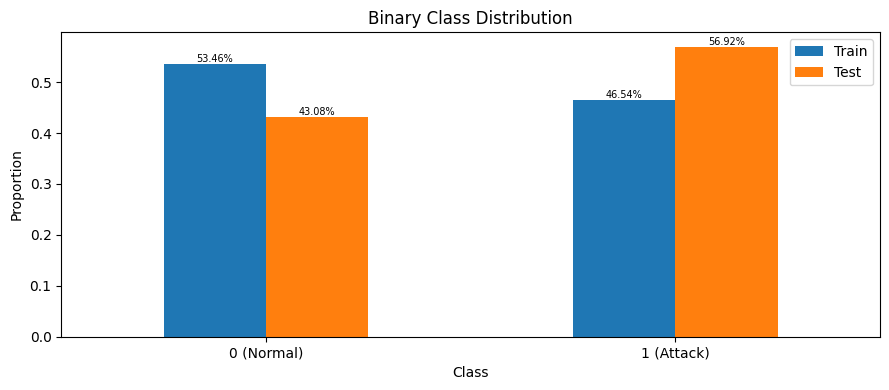

In [7]:
print("\n[4] Plotting class balance (Binary)...")

def plot_class_balance_binary(y_tr: np.ndarray, y_te: np.ndarray) -> None:
    tr = pd.Series(y_tr).value_counts(normalize=True).sort_index()
    te = pd.Series(y_te).value_counts(normalize=True).sort_index()
    dist = pd.DataFrame({"Train": tr, "Test": te}).fillna(0.0)

    ax = dist.plot(kind="bar", figsize=(9, 4))
    ax.set_title("Binary Class Distribution")
    ax.set_xlabel("Class")
    ax.set_ylabel("Proportion")
    ax.set_xticklabels(["0 (Normal)", "1 (Attack)"], rotation=0)
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.2%}",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha='center',
            va='bottom',
            fontsize=7,
            color='black',
            xytext=(0, 0),
            textcoords='offset points'
        )

    save_plot("split_distribution_binary")
    plt.show()

plot_class_balance_binary(y_train_binary, y_test_binary)

# ==========================================
# 6. Save Artifacts
# ==========================================

In [8]:
print("\n[4] Saving processed artifacts...")

np.save(PROCESSED_DIR / "X_train.npy", X_train_processed)
np.save(PROCESSED_DIR / "X_test.npy",  X_test_processed)

np.save(PROCESSED_DIR / "y_train_binary.npy", y_train_binary)
np.save(PROCESSED_DIR / "y_test_binary.npy",  y_test_binary)
np.save(PROCESSED_DIR / "y_train_multi.npy",  y_train_multi)
np.save(PROCESSED_DIR / "y_test_multi.npy",   y_test_multi)

if feature_names is not None:
    pd.DataFrame({"feature": feature_names}).to_csv(PROCESSED_DIR / "feature_names.csv", index=False)
    print(f"[+] Saved: {PROCESSED_DIR / 'feature_names.csv'}")

with open(PROCESSED_DIR / "preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)
print(f"[+] Saved: {PROCESSED_DIR / 'preprocessor.pkl'}")

print("[✓] Preprocessing complete.")



[4] Saving processed artifacts...
[+] Saved: ..\data\processed\feature_names.csv
[+] Saved: ..\data\processed\preprocessor.pkl
[✓] Preprocessing complete.
